# Keras Mobilenet 版的遷移學習範例 #
完整說明請見 [我的中文教學文]()。 本文件修改自 [erhat00/Deep-Learning](https://github.com/ferhat00/Deep-Learning/tree/master/Transfer%20Learning%20CNN)
也大推原作者的 [教學文](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)。 

前置作業：
1. 從 colab 的 Edit => Notebook Settings 進去，把 Hardware accelerator 設定成 GPU。
1. 把 ... 上傳到你的 google drive， 放在 ... 目錄下。
1. 掛載 google drive：

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [0]:
import os
os.chdir('/content/drive/My Drive/colab/ferhat00-keras-mobilenet/Transfer Learning CNN')

載入相依套件：

In [0]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam


Using TensorFlow backend.


建立 MobileNet。 原始論文： [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications, Howard et al, 2017
](https://arxiv.org/pdf/1704.04861.pdf)


In [0]:
mobile = keras.applications.mobilenet.MobileNet()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 1s 0us/step


In [0]:
!ls -l /root/.keras/models

total 16824
-rw-r--r-- 1 root root 17225924 Oct 11 13:27 mobilenet_1_0_224_tf.h5


In [0]:
def prepare_image(image_path, show=True):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    if show:
        display(Image(filename=image_path))
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

def mobile_cl(image_path, show=True):
    prepared = prepare_image(image_path)
    ans = mobile.predict(prepared)
    return imagenet_utils.decode_predictions(ans)


以下幾張圖片的狗狗所屬的品種都落在 [1000類標籤](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json) 當中：

In [0]:
mobile_cl('German_Shepherd.jpg')

In [0]:
mobile_cl('labrador1.jpg')

In [0]:
mobile_cl('poodle1.jpg') 

但是1000類標籤竟然不包含可愛的柴犬！

In [0]:
mobile_cl('shiba-inu.jpg') 

以下要把 MobileNet 來做遷移學習， 改訓練成狗狗動作判別器， 判斷一張圖片當中的狗正在做哪一件事： [其他、 跳、 睡、 游泳、 甩水、 伸展、 尿尿] 把底層的權重凍結起來、 最上面(最下游)那一層替換成三層 fully connected layers。

In [0]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 3s 0us/step


In [0]:
dog_behavior = Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

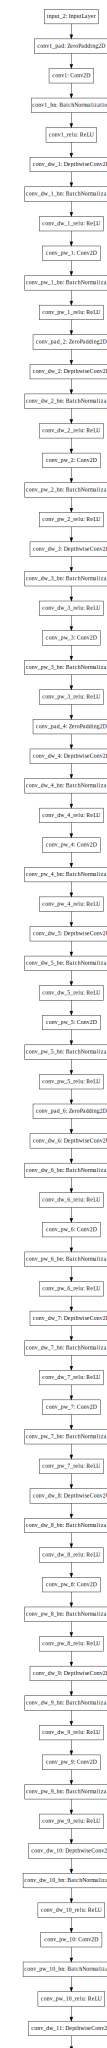

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model_dot = model_to_dot(dog_behavior)
model_dot.set_size('30')
SVG(model_dot.create(prog='dot', format='svg'))


以上畫圖從 [官網文件](https://keras.io/zh/visualization/) 學來的。 改變圖形大小從 [StackOverflow](https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook) 學來的。 效果好像不太好， 會被截掉。 還是用印的好了：

In [0]:
for i,layer in enumerate(dog_behavior.layers):
  print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

鎖住上游大部分的權重(保留既有、訓練好的權重)，只訓練/改變下游的權重。

In [0]:
for layer in dog_behavior.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in dog_behavior.layers[:20]:
    layer.trainable=False
for layer in dog_behavior.layers[20:]:
    layer.trainable=True

把訓練資料目錄餵給 ImageDataGenerator 。

In [0]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(
    'dog_behaviors', target_size=(224,224), batch_size=32,
    class_mode='categorical', color_mode='rgb', shuffle=True
)
label2id = train_generator.class_indices
id2label = [label2id[x] for x in label2id]
id2label = dict((v,k) for k,v in label2id.items())

Found 464 images belonging to 7 classes.


編譯完模型之後， 在 google colab 上用 GPU 訓練， 大約五分鐘。

In [0]:
dog_behavior.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
dog_behavior.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    epochs=10
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
14/14 [==============================] - 241s 17s/step - loss: 1.7089 - acc: 0.4596
Epoch 2/10
14/14 [==============================] - 25s 2s/step - loss: 0.5600 - acc: 0.8080
Epoch 3/10
14/14 [==============================] - 7s 503ms/step - loss: 0.3795 - acc: 0.8780
Epoch 4/10
14/14 [==============================] - 8s 540ms/step - loss: 0.1719 - acc: 0.9464
Epoch 5/10
14/14 [==============================] - 7s 517ms/step - loss: 0.3420 - acc: 0.9173
Epoch 6/10
14/14 [==============================] - 7s 532ms/step - loss: 0.2985 - acc: 0.9151
Epoch 7/10
14/14 [==============================] - 7s 532ms/step - loss: 0.1929 - acc: 0.9488
Epoch 8/10
14/14 [==============================] - 8s 557ms/step - loss: 0.2286 - acc: 0.9509
Epoch 9/10
14/14 [==============================] - 7s 529ms/step - loss: 0.2043 - acc: 0.9327
Epoch 10/10
14/14 [==============================

測試已訓練好的 dog_behavior 模型

In [0]:
def behavior_cl(image_path, show=True):
    prepared = prepare_image(image_path)
    ans = dog_behavior.predict(prepared)[0]
    best = sorted(range(len(ans)), key=lambda k: -ans[k])[:5]
    return ['{:6.2f}% {}'.format(ans[id]*100,id2label[id]) for id in best]


In [0]:
!ls

 220px-Poecile-atricapilla-001.jpg
 blue_tit.jpg
 crow.jpg
 dog_behaviors
 exam
 German_Shepherd.jpg
 labrador1.jpg
'MobileNet architecture.PNG'
 mobilenet_v1.png
 poodle1.jpg
 quiz
 shiba-inu.jpg
'Transfer Learning in Keras using MobileNet.ipynb'


In [0]:
from glob import glob
for f in sorted(glob('quiz/*.jpg')):
    print(f, behavior_cl(f))